In [1]:
 !nvidia-smi # gpu 정보 출력

Thu Apr 13 08:09:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# This mounts your google drive storage to this code
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

root = '/content/gdrive/My Drive/Test/'

# root = './' # 로컬 root일 경우
# if not os.path.exists(root):
#     os.makedirs(root)

Using cuda device


In [4]:
# settings for data normalization
# trans = transforms.Compose([transform.ToTensor(), transform.Normalize((0.5,),(1.0,))]) # normalize 평균, 표준편차
trans = transforms.ToTensor()
# trans = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip()])


train_data = datasets.FashionMNIST(
    root=root,
    train=True,
    download=True,
    transform=trans,
)

test_data = datasets.FashionMNIST(
    root=root,
    train=False,
    download=True,
    transform=trans,
)


batch_size = 64
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False)


In [5]:
# Linear Classification
# class LinearClassification(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.flatten = nn.Flatten()
#         self.linear = nn.Sequential(
#             nn.Linear(28*28, 10), # 출력 10개
#         )

#     def forward(self, x):
#         x = self.flatten(x) # x는 입력이미지
#         logits = self.linear(x)
#         return logits

# model = LinearClassification().to(device)
# print(model)


In [6]:
# # Multi-layer Perceptron
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(28*28, 512),
#             nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, 10)
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

# model = NeuralNetwork().to(device)
# print(model)


In [7]:
# define the CNN: 
# two convolution layers followed by two linear layers

class MyConvNet(nn.Module):   # nn.Module should be inherited for the neural network configuration so that it can work with backpropagation APIs
    def __init__(self):    # define layers: two conv layers and two linear (fully connected) layers 
        super(MyConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 5), # 입력채널(RGB) 1, 필터개수 32, 필터사이즈5X5 (가로세로 다르게 -> (5,3))
            nn.ReLU(), 
            nn.MaxPool2d(2,2), 
            nn.Conv2d(32, 64, 5), 
            nn.ReLU(), 
            nn.MaxPool2d(2,2), 
            nn.Flatten(), 
            nn.Linear(4*4*64, 512), # FC 레이어 4X4 사이즈가 64채널, 출력 512
            nn.Linear(512, 10)
        )
    
    # network connection: two conv layers, each followed by relu and max-pooling with (2x2) kernel, and two linear layer
    def forward(self, x):
        logits = self.conv_layers(x)
        return(logits)


# generate neural net model
model = MyConvNet().to(device)
print(model)


MyConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1024, out_features=512, bias=True)
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [8]:
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=1e-2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()
# def my_custom_loss(output, target): # Loss 함수 직접 정의 커스텀
#     return ((output-target)**2).sum()


In [9]:
# training and test

# epoch: 10
# data dimension: batch_size x Channels x Height x Width (NCHW)
for epoch in range(10):
    # training phase
    model.train()
    current_loss= 0.0
    for batch_num, (x, target) in enumerate(train_loader):
        x, target = x.to(device), target.to(device)

        # forward propagation
        out = model(x)
        loss = criterion(out,target)

        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        current_loss += loss
        
        # display the training loss in every 100 batches
        if (batch_num+1)%100 == 0 or (batch_num+1)%100 == len(train_loader):
            print('epoch: %d, batch_num: %d, current_loss: %.3f' %(epoch, batch_num+1, current_loss/100))
            current_loss = 0.0
    

    # test phase
    with torch.no_grad(): # test에선 결과값 영향 주지말라고 정의
        model.eval()
        total_samples = 0.0
        correct_samples = 0.0
        for (x, target) in test_loader:
            x, target = x.to(device), target.to(device)
            out = model(x)
            pred = torch.argmax(out,1) # 0번은 batch_dimesion
            correct_samples += (pred == target).sum() # 64개 중에 몇개 맞췄는지 나옴
        print('Accuracy: %.3f' %(100*float(correct_samples) / float(len(test_data)))) # Accuracy: 90.500


epoch: 0, batch_num: 100, current_loss: 0.852
epoch: 0, batch_num: 200, current_loss: 0.541
epoch: 0, batch_num: 300, current_loss: 0.475
epoch: 0, batch_num: 400, current_loss: 0.420
epoch: 0, batch_num: 500, current_loss: 0.418
epoch: 0, batch_num: 600, current_loss: 0.388
epoch: 0, batch_num: 700, current_loss: 0.367
epoch: 0, batch_num: 800, current_loss: 0.349
epoch: 0, batch_num: 900, current_loss: 0.346
Accuracy: 87.440
epoch: 1, batch_num: 100, current_loss: 0.302
epoch: 1, batch_num: 200, current_loss: 0.314
epoch: 1, batch_num: 300, current_loss: 0.314
epoch: 1, batch_num: 400, current_loss: 0.308
epoch: 1, batch_num: 500, current_loss: 0.299
epoch: 1, batch_num: 600, current_loss: 0.312
epoch: 1, batch_num: 700, current_loss: 0.308
epoch: 1, batch_num: 800, current_loss: 0.303
epoch: 1, batch_num: 900, current_loss: 0.277
Accuracy: 88.410
epoch: 2, batch_num: 100, current_loss: 0.258
epoch: 2, batch_num: 200, current_loss: 0.260
epoch: 2, batch_num: 300, current_loss: 0.267


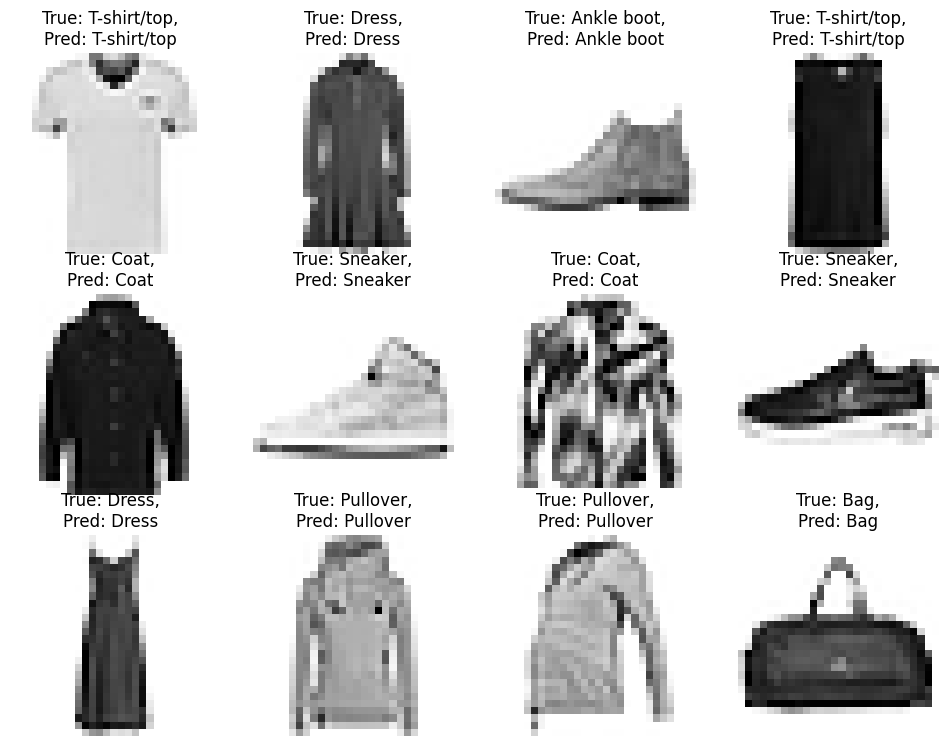

In [10]:
# Display Some test results 
import numpy as np 
import matplotlib.pyplot as plt

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# take one batch of the data
test_data, test_labels = next(iter(test_loader))   

# if cuda_available:
test_data, test_labels = test_data.to(device), test_labels.to(device)
out = model(test_data)              # put the test data to the trained network
pred = torch.argmax(out,1)          # prediction to the highest probability 


sample_index = np.random.choice(batch_size, size=12)     # take 12 random sample index
num_samples = sample_index.size

random_samples = test_data[sample_index].cpu().numpy()

plt.figure(figsize=(12, 12))

# display test samples
for k in range(num_samples):
    plt.subplot(4, 4, k + 1)
    plt.imshow(random_samples[k].reshape(28, 28),cmap='Greys')
    plt.title("True: " + str( classes[test_labels[sample_index[k]].item()]) + ",\nPred: " + str(classes[pred[sample_index[k]].item()]))
    plt.axis('off')

    
plt.show()

In [11]:
# save model
torch.save(model, 'my_CNN_model.pth') # root + "blabla.pth"

# load model
# model = torch.load('my_CNN_model.pth')

In [ ]:
# # save model weights
# torch.save(model.state_dict(), 'model_weights.pth') # 학습한 모델의 파라미터만 저장 -> 파일 사이즈 적고 슬림

# # load model weights # 파라미터만 저장해서 모델은 없음 -> 모델 불러와야됨
# model = MyConvNet() 
# model = LinearClassification()
# model.load_state_dict(torch.load('model_weights.pth'))
